In [1]:
### This script prepare external data(PC9, To) scatter plots and Venn diagrams for figure.py
# Author: Yiyun
import pandas as pd
from os.path import join
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np
from matplotlib_venn import venn2
from scipy.stats import gaussian_kde

In [3]:
### Load and read PC9 and To data
pc9_dir = '../out/21.0423 Lx PC9/L200only_reg_rf_boruta/anlyz'
to_dir = '../out/21.0506 Lx To/L200only_reg_rf_boruta/anlyz'
to_org_dir = '../data/DepMap/To'

df_pc9 = pickle.load(open(join(pc9_dir,'y_compr_ext.pkl'),'rb'))
df_to = pickle.load(open(join(to_dir,'y_compr_ext.pkl'),'rb'))
df_to_org = pd.read_csv(join(to_org_dir,'ToCellCERES.csv'), index_col = 0) #original to file containing drug names

In [5]:
### Format data for plotting
#PC9
df_pc9 = pd.concat([df_pc9['actual'],df_pc9['predicted']], axis = 0).T
df_pc9.columns = ['actual','predicted']

#To, scatter plot
# Drop DMSO and put all actual and predicted values together
df_to_actual = df_to['actual'].drop(0).melt(); df_to_predicted = df_to['predicted'].drop(0).melt()
df_to_scatter = pd.concat([df_to_actual['value'],df_to_predicted['value']],axis  =1)
df_to_scatter.columns = ['actual','predicted']

#To, Venn Diagram
df_to_venn = df_to
df_to_venn['actual'] = df_to['actual'].drop(0).T;df_to_venn['predicted'] = df_to['predicted'].drop(0).T
df_to_venn['actual'].columns = ['actual_'+ drug for drug in df_to_org.columns[1:]]
df_to_venn['predicted'].columns = ['predicted_'+ drug for drug in df_to_org.columns[1:]]
df_to_venn = pd.concat([df_to_venn['actual'],df_to_venn['predicted']], axis = 1)

***
### Scatter plot

Text(0, 0.5, 'Predicted')

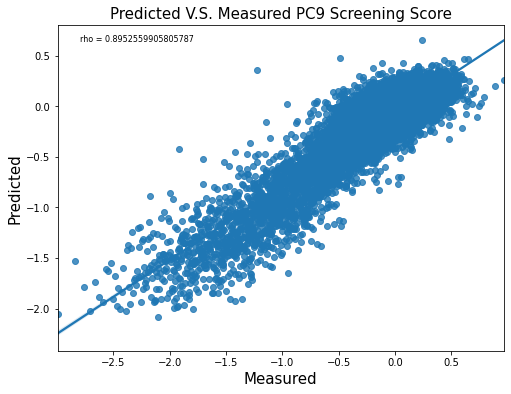

In [6]:
### Plot scatter plot
#PC9
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax = sns.regplot(x='actual', y='predicted',data = df_pc9)
corr = pearsonr(df_pc9['actual'], df_pc9['predicted'])[0]
ax.text(0.05,0.95,'rho = '+str(corr),transform=ax.transAxes,fontsize = 8) #add text
ax.set_title('Predicted V.S. Measured PC9 Screening Score', fontsize = 15)
ax.set_xlabel('Measured', fontsize=15);ax.set_ylabel('Predicted', fontsize=15)
# plt.savefig('PC9_exp_pred.pdf')

In [49]:
print(f'Pearson Correlation Coefficient for PC9 actual and predicted is:{corr}')

Pearson Correlation Coefficient for PC9 actual and predicted is:0.8952559905805787


In [158]:
# To
#------
#The scatter plot by density method is from Stackoverflow forum #53865762 (answered by Joe Kington)
#------
x = df_to_scatter['actual']; y =df_to_scatter['predicted']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

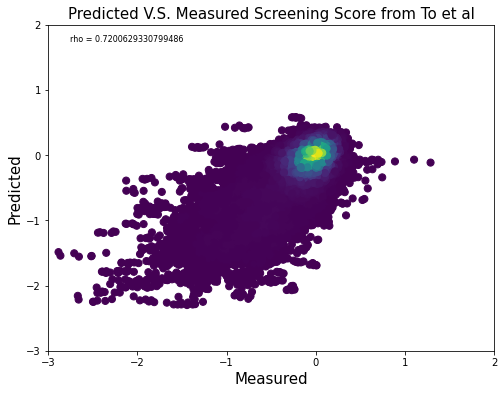

In [155]:
#Color the points according to density
fig, ax = plt.subplots()
fig.set_size_inches(8, 6)
ax.scatter(df_to_scatter['actual'], df_to_scatter['predicted'], c=z, s=50)
corr = pearsonr(df_to_scatter['actual'], df_to_scatter['predicted'])[0]
ax.text(0.05,0.95,'rho = '+str(corr),transform=ax.transAxes,fontsize = 8) #add text
ax.set_title('Predicted V.S. Measured Screening Score from To et al', fontsize = 15)
ax.set_xlabel('Measured', fontsize=15);ax.set_ylabel('Predicted', fontsize=15)
ax.set_ylim([-3,2])
ax.set_xlim([-3,2])
# plt.savefig('scatter_To.pdf')
# plt.show()

In [154]:
print(f'Pearson Correlation Coefficient for data from To et al actual and predicted is:{corr}')

Pearson Correlation Coefficient for data from To et al actual and predicted is:0.7200629330799486


***
### Venn diagram

In [7]:
### Function for getting hits in dataframes
def get_venn_subset(df, nhits, drug = None):

    drug = '_'+drug if drug else ''  # If given drug name

    top_actual = df['actual'+drug].T.sort_values().head(nhits).index
    top_predicted = df['predicted'+drug].T.sort_values().head(nhits).index
    intersect = len(set(top_actual).intersection(top_predicted))
    other = nhits-intersect
    
    return(other,other,intersect)

Text(0.5, 1.0, 'PC9 Predicted V.S. Measured top 500 hits')

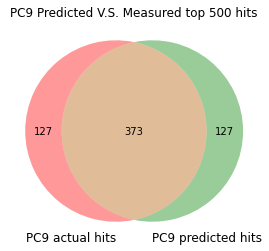

In [151]:
# PC9
nhit = 500
fig, ax = plt.subplots()
venn_subset = get_venn_subset(df_pc9,nhit)
venn2(subsets = venn_subset, set_labels = ('PC9 actual hits', 'PC9 predicted hits'))
ax.set_title(f'PC9 Predicted V.S. Measured top {nhit} hits')

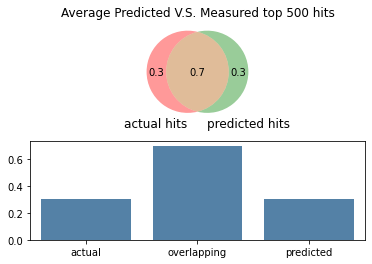

In [156]:
#To, average percent overlap
nhits = 500
ovp = []
for drug in df_to_org.columns[1:]:
    venn_subset = get_venn_subset(df_to_venn,500, drug = drug)
    ovp.append(venn_subset[2]/500)
ave_ovp = round(sum(ovp)/7,1); other = round(1-ave_ovp,1)
venn_subset = (other,other, ave_ovp)
bar_subset= (1-ave_ovp, ave_ovp,1-ave_ovp)

fig, axes = plt.subplots(2,1)
venn2(subsets = venn_subset, set_labels = ('actual hits', 'predicted hits'), ax = axes[0])
axes[0].set_title(f'Average Predicted V.S. Measured top {nhit} hits')
axes[1] = sns.barplot(['actual', 'overlapping','predicted'], bar_subset, color='steelblue')
# plt.savefig('average_overlap_to.pdf')

***
### Overlap hit list, not part for figure.py

In [129]:
def get_ovp_hits(df, nhits, drug = None):

    drug = '_'+drug if drug else ''  # If given drug name

    top_actual = df['actual'+drug].T.sort_values().head(nhits).index
    top_predicted = df['predicted'+drug].T.sort_values().head(nhits).index
    intersect = set(top_actual).intersection(top_predicted)
    
    df_pred = df.loc[top_predicted,:][['predicted'+drug]].reset_index()
    df_actual = df.loc[top_actual,:][['actual'+drug]].reset_index()
    df_ovp = pd.DataFrame(df.loc[intersect].index)
    
    df_all = pd.concat([df_actual,df_pred], axis = 1, ignore_index = True)
    df_all = pd.concat([df_all,df_ovp],axis = 1, ignore_index = True)
    df_all.columns = ['Gene_actual', 'CERES_actual','Gene_predicted','CERES_predicted','Gene_ovp' ]
    

    return df_all

In [121]:
df_pc9_ovp = get_ovp_hits(df_pc9, 500)
# df_pc9_ovp.to_csv('PC9_overlap.csv', index = False)

In [130]:
for drug in df_to_org.columns[1:]:
    df_to_ovp = get_ovp_hits(df_to_venn, 500, drug = drug)
#     df_to_ovp.to_csv(drug+'_overlap.csv', index = False)